# 1. Data

## 1.1 Imports

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error,make_scorer,precision_score,classification_report, confusion_matrix, plot_precision_recall_curve, plot_roc_curve,recall_score,precision_score, precision_recall_curve,f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb

from tensorflow import keras

## 1.2 Useful functions

In [2]:
def plot_report(model,X_test,y_test,model_name,figsize):
    
    '''Plots metrics, curves and the classification report'''
    
    f, ax = plt.subplots(nrows = 2, ncols = 2, figsize=figsize)

    '''Confusion matrix'''
    sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot = True, 
                cbar = False, ax= ax[0,0],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})
    
    ax[0,0].set_xlabel('Prediction',fontsize = 10)
    ax[0,0].set_ylabel('True',fontsize = 10)
    ax[0,0].set_title('Confusion matrix', fontsize = 15)
    
    
    '''Clasification report'''
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    sns.heatmap(pd.DataFrame(report).transpose()[['precision', 'recall','f1-score']], 
                annot = True, cbar = False,fmt='.2f', ax = ax[0,1], cmap= 'RdYlGn')
    ax[0,1].set_title('Classification report', fontsize = 15)


    '''PR Curve'''
    plot_precision_recall_curve(model,X_test,y_test,name = model_name, ax = ax[1,0])
    ax[1,0].set_title('Precision-Recall Curve', fontsize = 15)
    
    '''ROC Curve'''
    plot_roc_curve(model,X_test,y_test,name = model_name, ax = ax[1,1])
    ax[1,1].set_title('ROC', fontsize = 15)


    plt.tight_layout()
    plt.show()

In [3]:
def pred_report(pred,X_test,y_test,figsize):
    
    '''Plots metrics, curves and the classification report'''
    
    f, ax = plt.subplots(ncols = 2, figsize=figsize)

    '''Confusion matrix'''
    sns.heatmap(confusion_matrix(y_test,pred), annot = True, 
                cbar = False, ax= ax[0],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})
    
    ax[0].set_xlabel('Prediction',fontsize = 10)
    ax[0].set_ylabel('True',fontsize = 10)
    ax[0].set_title('Confusion matrix', fontsize = 15)
    
    
    '''Clasification report'''
    report = classification_report(y_test, pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).transpose()[['precision', 'recall','f1-score']], 
                annot = True, cbar = False,fmt='.2f', ax = ax[1], cmap= 'RdYlGn')
    ax[1].set_title('Classification report', fontsize = 15)

    plt.tight_layout()
    plt.show()

In [4]:
data = pd.read_csv("data/creditcard.csv")

## 1.3 EDA

In [3]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- **Time**: It is only a counter.
- **V1-V28**: Anonymized data.
- **Amount**: Transaction amount.
- **Class**: Fraud = 1, Normal = 0.

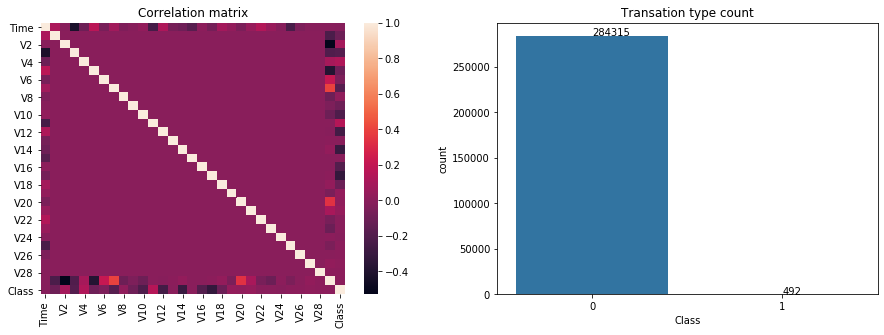

In [4]:
f, ax = plt.subplots(nrows=1 , ncols=2 ,figsize=(15,5))

sns.countplot(data["Class"], ax=ax[1])
ax[1].annotate(len(data[data["Class"]==1]),(1,len(data[data["Class"]==1])))
ax[1].annotate(len(data[data["Class"]==0]),(0,len(data[data["Class"]==0])))
sns.heatmap(data.corr(), ax=ax[0])

ax[1].set_title("Transation type count")
ax[0].set_title("Correlation matrix")

plt.show()

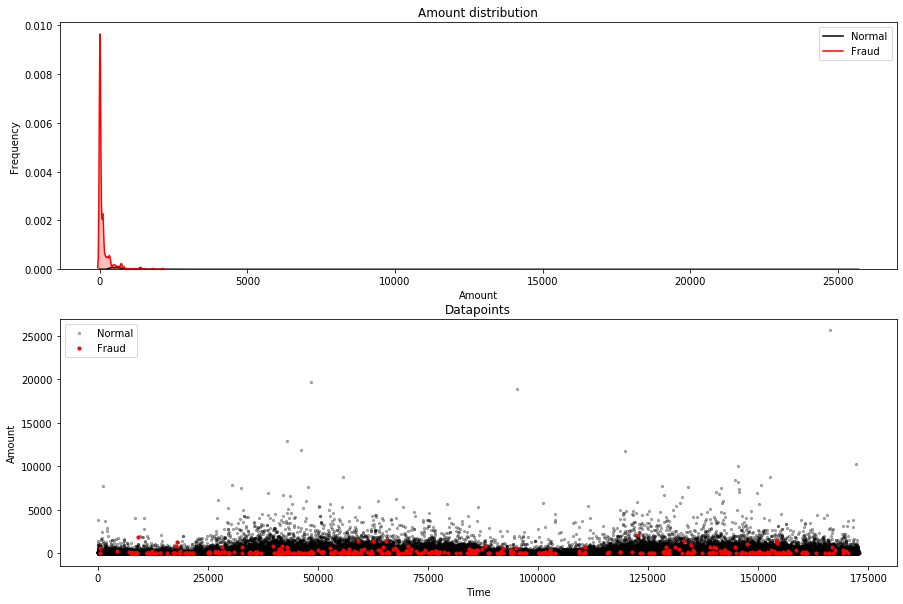

In [5]:
f, ax = plt.subplots(nrows = 2,figsize=(15,10))

sns.kdeplot(data[data["Class"]==0]["Amount"],shade=True,color='k',label='Normal',ax = ax[0])
sns.kdeplot(data[data["Class"]==1]["Amount"],shade=True,color='r',label='Fraud',ax = ax[0])

ax[0].set_title('Amount distribution')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Amount')

ax[1].scatter(data[data["Class"]==0]["Time"],
            data[data["Class"]==0]["Amount"],
            s=5,alpha=0.3,
            label="Normal",
            c="k")

ax[1].scatter(data[data["Class"]==1]["Time"],
            data[data["Class"]==1]["Amount"],
            s=10,
            label="Fraud",
            c="r")

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Amount")
ax[1].set_title('Datapoints')

plt.legend()
plt.show()

This dataset has high dimentionality, so visualization is a problem. Doing pairplots for every variable isn't functional, so I proced with a t-SNE technique to get a 2D plot of the data. Also, I will take only a subsample of normal class for this viz.

In [157]:
subdata = data.copy()
subdata.iloc[:,1:30] = RobustScaler().fit_transform(subdata.iloc[:,1:30])

tsne = TSNE(n_components=2, random_state = 26)
subsample = pd.concat([subdata[subdata['Class']==0].sample(150000),subdata[subdata['Class']==1]])
data_viz = tsne.fit_transform(subsample.drop('Class',axis=1))

color = ['red' if i == 1 else 'k' for i in subsample['Class']]
size = [10 if i == 1 else 1 for i in subsample['Class']]


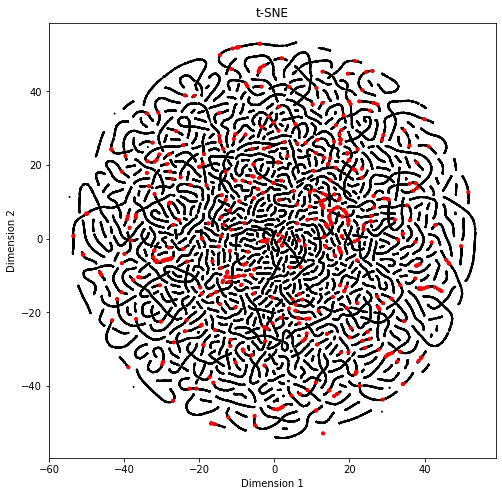

In [158]:
plt.figure(figsize=(8,8))
plt.scatter(pd.DataFrame(data_viz)[0],pd.DataFrame(data_viz)[1], color = color,  s= size)
plt.title('t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

The red dots represent frauds, and there are very close to normal transaction.

# 2. Models

## 2.1 LogisticRegression - Baseline

In [149]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Class','Time'],axis=1),
                                                    data['Class'],
                                                    test_size = 0.2, random_state = 26)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.2, random_state = 26)

In [71]:
baseline = Pipeline([('scaler',RobustScaler()),
                     ('classifier',LogisticRegression(max_iter = 100000))])

baseline.fit(pd.concat([X_train,X_val]),np.concatenate((y_train,y_val)))

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

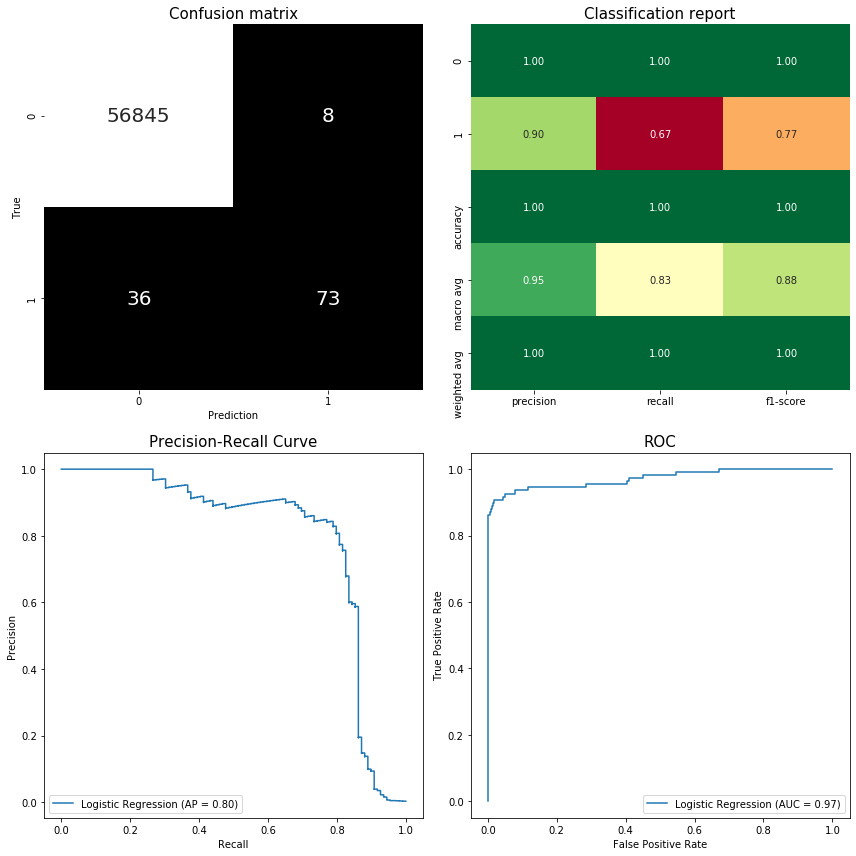

In [72]:
plot_report(baseline,X_test,y_test,'Logistic Regression',(12,12))

In [73]:
test_results = {}
logistic_regression = {'TP':73,'TN':56845,'FP':8,'FN':36,'Recall':0.67,'Precision':0.90,'F1-Score':0.77,'Macro avg recall':0.83}
test_results['LR'] = logistic_regression

## 2.2 LogisticRegression with resampling

- Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented).

1. **Random Oversampling** involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once (2x, 3x, 5x, 10x, etc.) This is one of the earliest proposed methods, that is also proven to be robust. Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement.

2. **Random Undersampling:** Randomly remove samples from the majority class, with or without replacement. This is one of the earliest techniques used to alleviate imbalance in the dataset, however, it may increase the variance of the classifier and may potentially discard useful or important samples.

![Under/Over sampling](images/resampling1.jpg)

3. **SMOTE:** take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point. 

![SMOTE](images/smote.png)


4. **Class weight:** provide a weight for each class which places more emphasis on the minority classes such that the end result is a classifier which can learn equally from all classes. For example:

    - ```class_1``` has 1000 instances and ```class_2``` 100 instances.
    - ```class_weights={"class_1": 1, "class_2": 10}```
    - In other words, this would mean that if the model makes a mistake where the true label is ```class_2 ```it is going to be penalized 10 times more than if it makes a mistake on a sample where the true class is ```class_1``` 
    
*Source:*
- *https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis*
- *https://stackoverflow.com/questions/53860734/adding-class-weights-for-imbalanced-dataset-in-convolutional-neural-network*

In [74]:
classweight = Pipeline_imb([('scaler',RobustScaler()),
                            ('classifier',LogisticRegression(max_iter = 100000,
                                                             class_weight = 'balanced'))])

undersampling = Pipeline_imb([('scaler',RobustScaler()),
                              ('undersampling',RandomUnderSampler(random_state = 26)),
                              ('classifier',LogisticRegression(max_iter = 100000))])

oversampling = Pipeline_imb([('scaler',RobustScaler()),
                             ('undersampling',RandomOverSampler(random_state = 26)),
                             ('classifier',LogisticRegression(max_iter = 100000))])

smote = Pipeline_imb([('scaler',RobustScaler()),
                      ('undersampling',SMOTE(random_state = 26)),
                      ('classifier',LogisticRegression(max_iter = 100000))])


classweight.fit(X_train,y_train)
undersampling.fit(X_train,y_train)
oversampling.fit(X_train,y_train)
smote.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('undersampling',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=26,
                       sampling_strategy='auto')),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

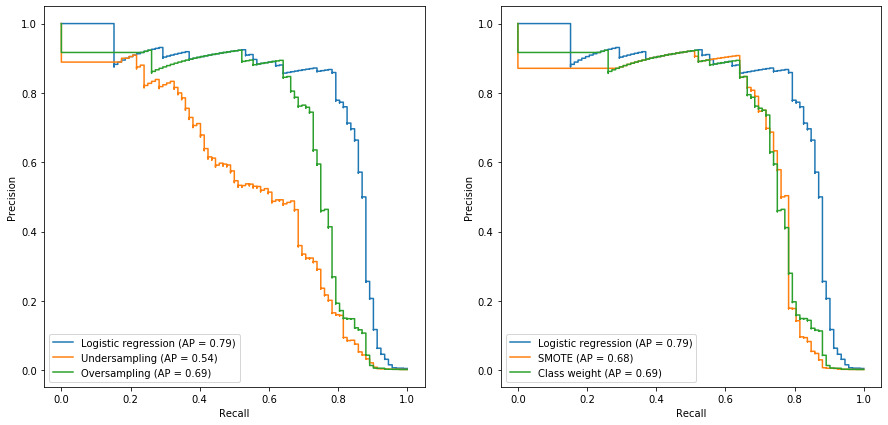

In [75]:
f, ax = plt.subplots(ncols = 2, figsize=(15,7))

'''PR Curve'''
plot_precision_recall_curve(baseline,X_val,y_val,name = 'Logistic regression',ax=ax[0])
plot_precision_recall_curve(undersampling,X_val,y_val,name = 'Undersampling',ax=ax[0])
plot_precision_recall_curve(oversampling,X_val,y_val,name = 'Oversampling',ax=ax[0])


'''PR Curve'''
plot_precision_recall_curve(baseline,X_val,y_val,name = 'Logistic regression',ax=ax[1])
plot_precision_recall_curve(smote,X_val,y_val,name = 'SMOTE',ax=ax[1])
plot_precision_recall_curve(classweight,X_val,y_val,name = 'Class weight',ax=ax[1])

plt.show()

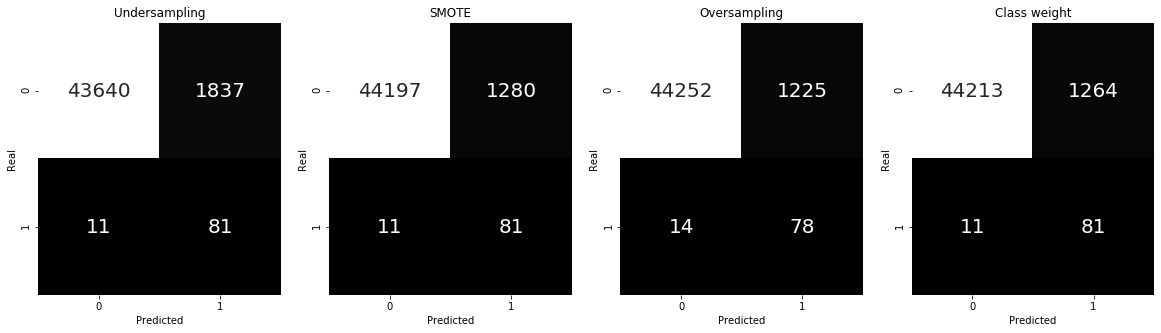

In [76]:
f,ax = plt.subplots( ncols = 4, figsize=(20,5))

sns.heatmap(confusion_matrix(y_val,undersampling.predict(X_val)), annot = True, 
            cbar = False, ax= ax[0],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val,oversampling.predict(X_val)), annot = True, 
            cbar = False, ax= ax[1],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val,smote.predict(X_val)), annot = True, 
            cbar = False, ax= ax[2],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val,classweight.predict(X_val)), annot = True, 
            cbar = False, ax= ax[3],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

ax[0].set_title('Undersampling')
ax[1].set_title('SMOTE')
ax[2].set_title('Oversampling')
ax[3].set_title('Class weight')

ax[0].set_xlabel('Predicted')
ax[1].set_xlabel('Predicted')
ax[2].set_xlabel('Predicted')
ax[3].set_xlabel('Predicted')

ax[0].set_ylabel('Real')
ax[1].set_ylabel('Real')
ax[2].set_ylabel('Real')
ax[3].set_ylabel('Real')

plt.show()

We have reached more recall with all the methods, but also we have more False Positives. This is a classic trade off between detecting all fraud and getting more FP or having a low FP and less frauds detected.


Metrics:
https://github.com/leogcalderon/Applied_ML2020/tree/master/Evaluation

Imbalanced:
https://github.com/leogcalderon/Applied_ML2020/tree/master/Imbalanced

In [77]:
lrr = recall_score(y_val,baseline.predict(X_val))
usr = recall_score(y_val,undersampling.predict(X_val))
ovr = recall_score(y_val,oversampling.predict(X_val))
sr = recall_score(y_val,smote.predict(X_val))
cwr = recall_score(y_val,classweight.predict(X_val))

headers = ['Logistic regression','Undersampling','Oversampling','SMOTE','Class weight']
print('Recall\n--------------------------------------------------------------------------------')
print(f'{headers[0]:>15s}{headers[1]:>15s}{headers[2]:>15s}{headers[3]:>14s}{headers[4]:>20s}')
print(f'{lrr:^20.2f}{usr:^15.2f}{ovr:^15.2f}{sr:^20.2f}{cwr:^15.2f}')

lrp = precision_score(y_val,baseline.predict(X_val))
usp = precision_score(y_val,undersampling.predict(X_val))
ovp = precision_score(y_val,oversampling.predict(X_val))
srp = precision_score(y_val,smote.predict(X_val))
cwp = precision_score(y_val,classweight.predict(X_val))

headers = ['Logistic regression','Undersampling','Oversampling','SMOTE','Class weight']
print('\n\nPrecision\n--------------------------------------------------------------------------------')
print(f'{headers[0]:>15s}{headers[1]:>15s}{headers[2]:>15s}{headers[3]:>14s}{headers[4]:>20s}')
print(f'{lrp:^20.2f}{usp:^15.2f}{ovp:^15.2f}{srp:^20.2f}{cwp:^15.2f}')

Recall
--------------------------------------------------------------------------------
Logistic regression  Undersampling   Oversampling         SMOTE        Class weight
        0.55             0.88           0.88              0.85             0.88      


Precision
--------------------------------------------------------------------------------
Logistic regression  Undersampling   Oversampling         SMOTE        Class weight
        0.89             0.04           0.06              0.06             0.06      


Also,we can change the threshold for our classifier. With the F-Score (harmonic mean of recall and precision) we can find the threshold that "maximizes both values at the same time" (because we are search the best combination of both, not only max one).

*Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/*

In [78]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [82]:
probs = smote.predict_proba(X_val)[:,1]
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)

print('Threshold=%.3f \nF-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.999 
F-Score=0.72131


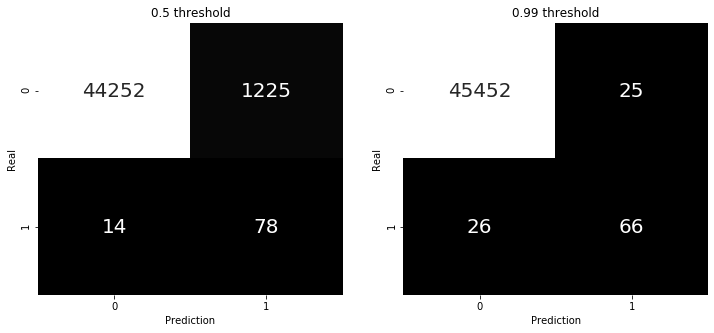

In [83]:
f,ax = plt.subplots( ncols = 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_val,smote.predict(X_val)), annot = True, 
            cbar = False, ax = ax[0], fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val, to_labels(probs,thresholds[ix])), annot = True, 
            cbar = False,ax = ax[1], fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

ax[0].set_title('0.5 threshold')
ax[1].set_title('0.99 threshold')

ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Real')

ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Real')

plt.show()

We can see that in the validation set the classifier have 98% (1225 to 25) less False Positives, but the False Negatives have increased 86%% (14 to 26). Also we have 15% less frauds detected (78 to 66) 

So, depending on our goals it is our threshold:
- We want to catch the vast majority of frauds ?
- We want to catch most of the frauds and have a low false positive ?

**The final model for Logistic Regression will be:**
- SMOTE technique for resampling
- Threshold = 0.999

In [90]:
lr_pipe = Pipeline_imb([('scaler',RobustScaler()),
                        ('smote',SMOTE()),
                        ('model',LogisticRegression(max_iter=10000))])

lr_pipe.fit(pd.concat([X_train,X_val]),np.concatenate((y_train,y_val)))

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

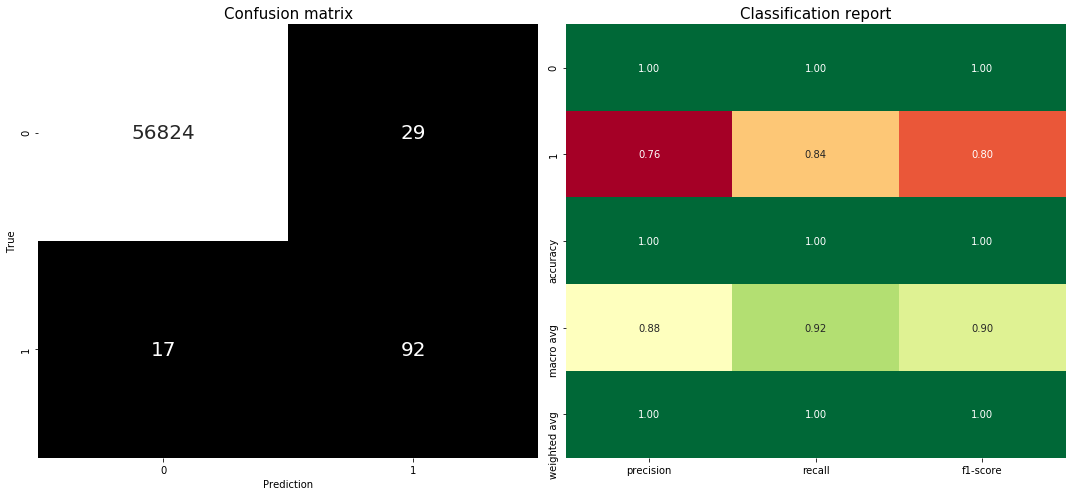

In [91]:
pred = to_labels(lr_pipe.predict_proba(X_test)[:,1],thresholds[ix])
pred_report(pred,X_test,y_test,(15,7))

In [92]:
logistic_regression_smote = {'TP':92,'TN':56824,'FP':29,'FN':17,'Recall':0.84,'Precision':0.76,'F1-Score':0.80,'Macro avg recall':0.92}
test_results['LR+SMOTE'] = logistic_regression_smote

With this final model I wasn't able to perform Cross validation because in Sklearn we can not change the threshold for the model, it only can be changed by brute force.

## 2.2 Isolation forest

- Tries to isolate instances, it is performed by building an ensemble of trees. 
- More steps are needed to isolate "normal" points, and its only takes a few steps to isolate "anomalous" points. So we assign scores to the points that lies in certain leaves.
- If lies in a close one, it will have a high score (potential anomaly) and if it lies on a further leaf, it will have a low score.

![Isolation Forest](images/isolation.png)

*Source: https://www.youtube.com/watch?v=ttRyN9puC6E*

*Contamination:* The amount of contamination of the data set, i.e. the proportion
of outliers in the data set. Used when fitting to define the threshold
on the scores of the samples.

- GridSearchCV doesn't work very well with isolation forest, so I did the search manually altought this approach will be overfitting our validation set

In [45]:
contaminations = np.arange(0.0075, 0.04, 0.005)
scores = {}

for c in contaminations:
    model = IsolationForest(n_jobs = -1, contamination=c).fit(X_train,y_train)
    pred = pd.Series(model.predict(X_val)).map({1:0,-1:1})
    r,p,f1 = recall_score(y_val,pred), precision_score(y_val,pred), f1_score(y_val,pred)
    scores[c] = [r,p,f1]
    print(c,'Done')

0.0075 Done
0.0125 Done
0.0175 Done
0.022500000000000003 Done
0.027500000000000004 Done
0.0325 Done
0.037500000000000006 Done


In [46]:
import pprint
pprint.pprint(scores)

{0.0075: [0.5512820512820513, 0.125, 0.2037914691943128],
 0.0125: [0.5897435897435898, 0.08333333333333333, 0.146031746031746],
 0.0175: [0.6410256410256411, 0.06451612903225806, 0.11723329425556857],
 0.022500000000000003: [0.6666666666666666,
                        0.05083088954056696,
                        0.09445958219800182],
 0.027500000000000004: [0.7435897435897436,
                        0.0475799835931091,
                        0.08943716268311487],
 0.0325: [0.8205128205128205, 0.04380561259411362, 0.08317089018843404],
 0.037500000000000006: [0.8205128205128205,
                        0.038027332144979206,
                        0.07268597387847814]}


In [47]:
params_estimators = [50, 75, 100, 125, 150, 200, 250]
scores = {}

for e in params_estimators:
    model = IsolationForest(n_jobs = -1, n_estimators = e, contamination = 0.0325).fit(X_train,y_train)
    pred = pd.Series(model.predict(X_val)).map({1:0,-1:1})
    r,p,f1 = recall_score(y_val,pred), precision_score(y_val,pred), f1_score(y_val,pred)
    scores[e] = [r,p,f1]
    print(e,'Done')

50 Done
75 Done
100 Done
125 Done
150 Done
200 Done
250 Done


In [48]:
pprint.pprint(scores)

{50: [0.7692307692307693, 0.0411522633744856, 0.078125],
 75: [0.8205128205128205, 0.04510218463706836, 0.08550434201736806],
 100: [0.8076923076923077, 0.04265402843601896, 0.08102893890675242],
 125: [0.7564102564102564, 0.04046639231824417, 0.07682291666666667],
 150: [0.8333333333333334, 0.044796691936595454, 0.08502289077828647],
 200: [0.8205128205128205, 0.04365620736698499, 0.0829015544041451],
 250: [0.7948717948717948, 0.04314544189283229, 0.08184818481848184]}


In [53]:
params_max_samples= np.arange(0.25, 1.25, 0.25)
scores = {}

for m in params_max_samples:
    model = IsolationForest(n_jobs = -1, n_estimators = 150, contamination = 0.0325, max_samples = m).fit(X_train,y_train)
    pred = pd.Series(model.predict(X_val)).map({1:0,-1:1})
    r,p,f1 = recall_score(y_val,pred), precision_score(y_val,pred), f1_score(y_val,pred)
    scores[m] = [r,p,f1]
    print(m,'Done')

0.25 Done
0.5 Done
0.75 Done
1.0 Done


In [54]:
pprint.pprint(scores)

{0.25: [0.8333333333333334, 0.044796691936595454, 0.08502289077828647],
 0.5: [0.8333333333333334, 0.04412763068567549, 0.08381689232753062],
 0.75: [0.8333333333333334, 0.04485852311939269, 0.08513425016371971],
 1.0: [0.8333333333333334, 0.044735030970406056, 0.08491182233834095]}


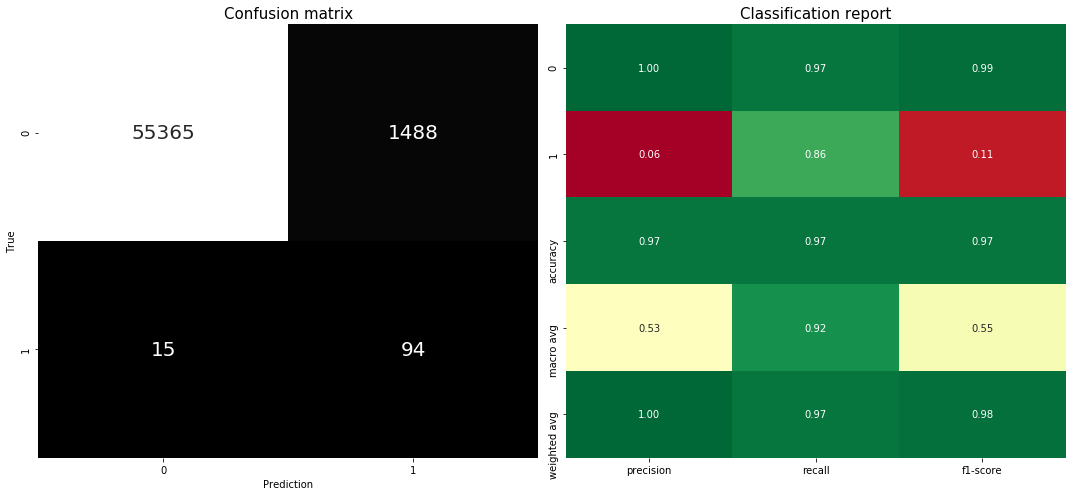

In [93]:
final_if = IsolationForest(n_jobs = -1, n_estimators = 50, contamination = 0.0275, max_samples = 0.25)
final_if.fit(pd.concat([X_train,X_val]),np.concatenate((y_train,y_val)))

pred = pd.Series(final_if.predict(X_test)).map({1:0,-1:1})
pred_report(pred,X_test,y_test,(15,7))

In [94]:
isolation_forest_results = {'TP':94,'TN':55365,'FP':1488,'FN':15,'Recall':0.86,'Precision':0.06,'F1-Score':0.11,'Macro avg recall':0.92}
test_results['IsolationForest'] = isolation_forest_results

## 2.3 Autoencoder

- An autoencoder is a encoder-decoder type of neural network architectura that is used for self-learning from unlabeled data.
- The idea is to learn how to compress data into a concise representation to allow for the reconstruction with minimun error.
![Autoencoder](images/autoencoder.png)

1. First, we train the autoencoder with non fraud data. The output of the AE will be a reconstructed vector of the input, with the same dimensions.
2. Then, we pass non fraud test data, and que measure the error between the input and output. With this error we define a error threshold. If a data point has a higher error than this threshold, it is considerer an anomaly.

In [102]:
print('Input and output dimention of the AutoEncoder =',X_train.shape[1])

Input and output dimention of the AutoEncoder = 29


We have to have only "normal" transaction to train this model first.

In [166]:
X_train['Class'] = y_train
X_val['Class'] = y_val

In [174]:
X_train_normal = X_train[X_train['Class'] == 0].drop('Class',axis = 1)
X_train_fraud = X_train[X_train['Class'] == 1].drop('Class',axis = 1)

X_val_normal = X_val[X_val['Class'] == 0].drop('Class',axis = 1)
X_val_fraud = X_val[X_val['Class'] == 1].drop('Class',axis = 1)

scaler = RobustScaler().fit(X_train_normal)
X_train_normal = scaler.transform(X_train_normal)
X_train_fraud = scaler.transform(X_train_fraud)
X_val_normal = scaler.transform(X_val_normal)
X_val_fraud = scaler.transform(X_val_fraud)

X_test_ae = scaler.transform(X_test)

In [175]:
ae = keras.Sequential()
ae.add(keras.layers.Dense(10, input_dim = X_train_normal.shape[1], activation='relu'))
ae.add(keras.layers.Dense(5, activation='relu')) #LATENT REPRESENTATION
ae.add(keras.layers.Dense(10, activation='relu'))
ae.add(keras.layers.Dense(X_train_normal.shape[1]))
ae.compile(loss='mean_squared_error', optimizer='adam')

In [176]:
ae.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 10)                300       
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_49 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_50 (Dense)             (None, 29)                319       
Total params: 734
Trainable params: 734
Non-trainable params: 0
_________________________________________________________________


In [177]:
hist = ae.fit(X_train_normal,X_train_normal,epochs=50,verbose = 2)

Epoch 1/50
5688/5688 - 8s - loss: 1.2355
Epoch 2/50
5688/5688 - 8s - loss: 0.7935
Epoch 3/50
5688/5688 - 8s - loss: 0.7024
Epoch 4/50
5688/5688 - 8s - loss: 0.6352
Epoch 5/50
5688/5688 - 9s - loss: 0.6142
Epoch 6/50
5688/5688 - 8s - loss: 0.5999
Epoch 7/50
5688/5688 - 8s - loss: 0.5926
Epoch 8/50
5688/5688 - 9s - loss: 0.5920
Epoch 9/50
5688/5688 - 9s - loss: 0.5834
Epoch 10/50
5688/5688 - 9s - loss: 0.5811
Epoch 11/50
5688/5688 - 8s - loss: 0.5828
Epoch 12/50
5688/5688 - 8s - loss: 0.5792
Epoch 13/50
5688/5688 - 8s - loss: 0.5802
Epoch 14/50
5688/5688 - 8s - loss: 0.5773
Epoch 15/50
5688/5688 - 8s - loss: 0.5772
Epoch 16/50
5688/5688 - 8s - loss: 0.5775
Epoch 17/50
5688/5688 - 8s - loss: 0.5755
Epoch 18/50
5688/5688 - 8s - loss: 0.5724
Epoch 19/50
5688/5688 - 8s - loss: 0.5709
Epoch 20/50
5688/5688 - 8s - loss: 0.5681
Epoch 21/50
5688/5688 - 8s - loss: 0.5686
Epoch 22/50
5688/5688 - 8s - loss: 0.5657
Epoch 23/50
5688/5688 - 8s - loss: 0.5667
Epoch 24/50
5688/5688 - 9s - loss: 0.5645
E

In [179]:
pred_normal = ae.predict(X_train_normal)
pred_fraud = ae.predict(X_train_fraud)

score_train_normal = np.sqrt(mean_squared_error(X_train_normal,pred_normal))
score_train_fraud = np.sqrt(mean_squared_error(X_train_fraud,pred_fraud))

print('Normal error - Training data:',score_train_normal)
print('Fraud error - Training data:',score_train_fraud)

Normal error - Training data: 0.743081215361977
Fraud error - Training data: 4.427949647965656


In [191]:
def error(true, representation):
    errors = []
    for i in range(representation.shape[0]):
        e = np.sqrt(mean_squared_error(representation[i], true[i]))
        errors.append(e)
    return errors

In [198]:
errors_fraud = error(X_train_fraud,pred_fraud)
errors_normal = error(X_train_normal,pred_normal)

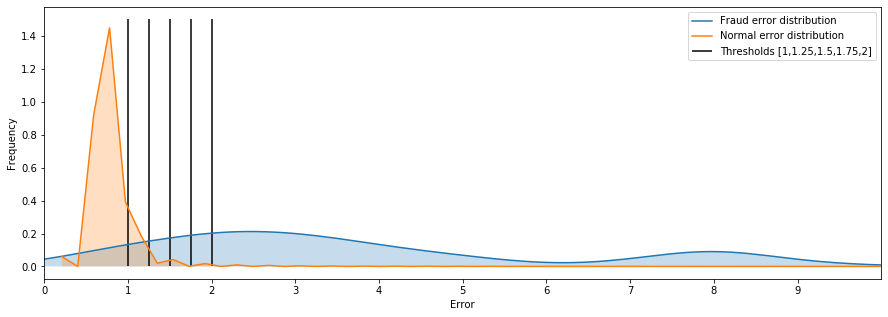

In [275]:
plt.figure(figsize=(15,5))
sns.kdeplot(errors_fraud,shade=True,label='Fraud error distribution')
sns.kdeplot(errors_normal,shade=True,label='Normal error distribution')
plt.vlines([1,1.25,1.5,1.75,2],0,1.5,label='Thresholds [1,1.25,1.5,1.75,2]')
plt.xticks(np.arange(0,10,1))
plt.xlim([0,10])
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Now, we can adjust the threshold to decide wich data point is considered fraud. I will adjust it with the validation set and later, I will test the autoencoder with the test set.

In [242]:
thresholds = [1, 1.25, 1.5, 1.75, 2]
val = scaler.transform(X_val.drop('Class',axis = 1))
pred_val = ae.predict(val)

In [243]:
errors_val = error(val,pred_val)

In [244]:
predictions = {}
for thr in thresholds:
    predictions[thr] = [ 1 if i >= thr else 0 for i in errors_val]

In [260]:
for thr in thresholds:
    print('Threshold = ', thr)
    print('---------------')
    print('Recall:',round(recall_score(y_val,predictions[thr])*100,2),'%')
    print('Precision:',round(precision_score(y_val,predictions[thr])*100,2),'%')
    print('F1:',round(f1_score(y_val,predictions[thr])*100,2),'%\n\n\n')

Threshold =  1
---------------
Recall: 90.22 %
Precision: 2.48 %
F1: 4.84 %



Threshold =  1.25
---------------
Recall: 85.87 %
Precision: 6.71 %
F1: 12.44 %



Threshold =  1.5
---------------
Recall: 82.61 %
Precision: 11.91 %
F1: 20.82 %



Threshold =  1.75
---------------
Recall: 79.35 %
Precision: 16.74 %
F1: 27.65 %



Threshold =  2
---------------
Recall: 72.83 %
Precision: 20.43 %
F1: 31.9 %





In [265]:
X_test_scaled = scaler.transform(X_test)

error_test = error(ae.predict(X_test_scaled),X_test_scaled)

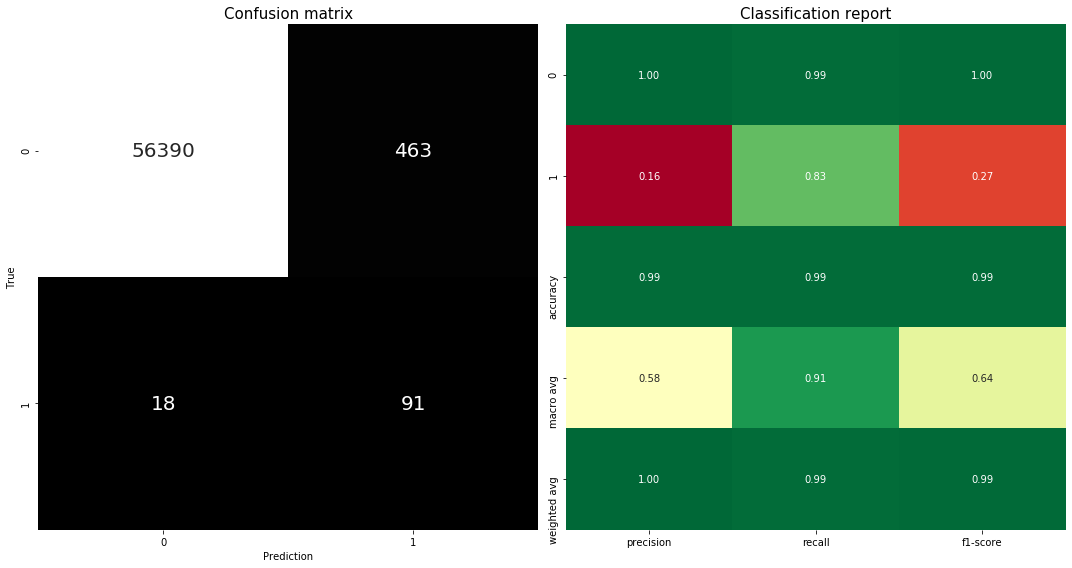

In [269]:
pred_test = [ 1 if i >= 1.75 else 0 for i in error_test]
pred_report(pred_test,X_test,y_test,(15,8))

In [270]:
autoencoder_results = {'TP':91,'TN':56390,'FP':463,'FN':18,'Recall':0.83,'Precision':0.16,'F1-Score':0.27,'Macro avg recall':0.91}
test_results['Autoencoder'] = autoencoder_results

## 2.4 Models resume

In [271]:
pd.DataFrame(test_results)

,LR,LR+SMOTE,IsolationForest,Autoencoder
TP,73.00,92.00,94.00,91.00
TN,56845.00,56824.00,55365.00,56390.00
FP,8.00,29.00,1488.00,463.00
FN,36.00,17.00,15.00,18.00
Recall,0.67,0.84,0.86,0.83
Precision,0.90,0.76,0.06,0.16
F1-Score,0.77,0.80,0.11,0.27
Macro avg recall,0.83,0.92,0.92,0.91


- The model that have the best trade off between recall and precision is the Logistic Regression with a SMOTE resampling.
- All the models are very sensitive to a change in the threshold, so depending in what are our goals (get all frauds or try to get some and less False Positives) is going to be our scores.
- The Logistic Regression and the autoencoder have not tuning, so the score might be increased if we tune them.
- Another approach to classify with the autoencoders is to get the Latent representation and then make a simple classificator like LR or SVC to get the frauds.